In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [33]:
def generate_data(num_samples, num_points = 20):
    data = np.zeros((num_samples,2,num_points))
    coeffs = np.zeros(num_samples)
    for i in range(num_samples):
        coeff = np.random.uniform(0, 10, 1)
        # print(coeff)
        x = np.random.uniform(0, 10, num_points)
        # print("x",x)
        # Generate y values with noise
        noise = np.random.normal(0, 0.5*coeff, num_points)
        y = coeff * x + noise
        # print("y",y)
        data[i,:,:] = np.vstack((x,y))
        # print(np.vstack((x,y)))
        # print(coeff[0])
        coeffs[i] = coeff[0]
    return data,coeffs
    

# Generate some example data
example_data = generate_data(10)
# print(example_data)
train_data = generate_data(200000)
print(train_data[0].shape)
val_data = generate_data(100)

class TrendlineDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):
        slice_i = torch.tensor(np.take(self.data[0], indices=idx, axis=0), dtype=torch.float32)
        # print("slice", slice_i.shape)
        target = torch.tensor(np.array([self.data[1][idx]]),dtype=torch.float32)
        # print("target", target)
        return slice_i, target

train_dataset = TrendlineDataset(train_data)
print(train_dataset[0])
val_dataset = TrendlineDataset(val_data)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
print(next(iter(train_loader))[0].shape)

(200000, 2, 20)
(tensor([[ 7.0264e-01,  2.0488e+00,  5.9533e+00,  7.8011e+00,  6.2612e-01,
          7.2324e+00,  8.0198e-01,  9.1257e+00,  8.5697e+00,  1.2121e+00,
          3.4317e+00,  9.7900e+00,  3.7711e-01,  5.5761e+00,  1.1312e+00,
          8.5211e+00,  9.8144e+00,  1.4240e-03,  1.5727e+00,  7.6832e+00],
        [ 1.7873e+00,  1.7872e+01,  3.4707e+01,  4.2823e+01,  5.9104e-01,
          4.8937e+01,  2.0620e+00,  5.3249e+01,  5.4188e+01,  1.0034e+01,
          1.7260e+01,  6.3802e+01,  7.4342e+00,  3.2650e+01,  4.7008e+00,
          5.3181e+01,  5.7170e+01, -1.6102e+00,  9.0995e+00,  4.8630e+01]]), tensor([5.9778]))
torch.Size([256, 2, 20])


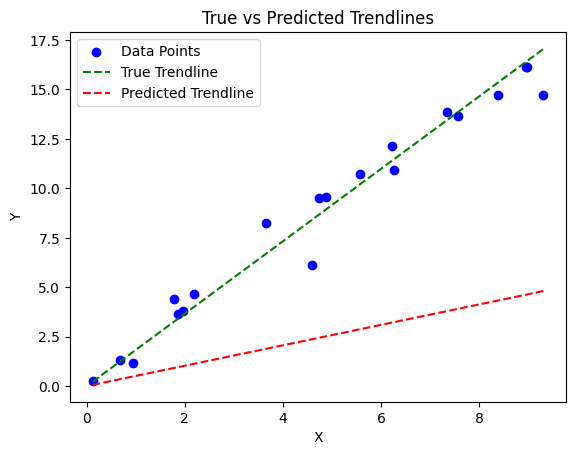

/usr/local/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 13.334468841552734
epoch 1, loss 12.845980644226074


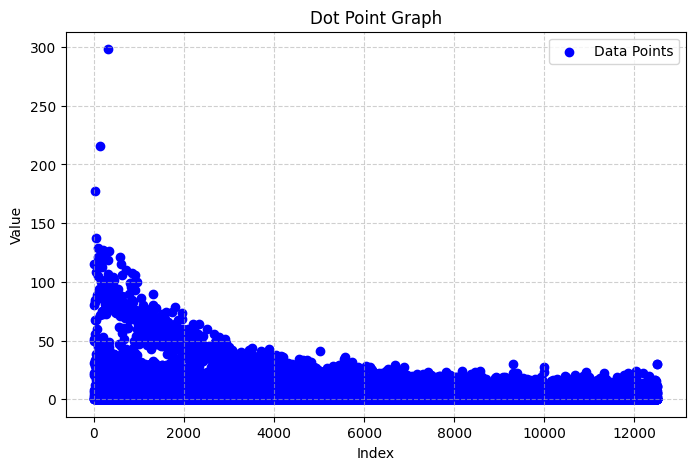

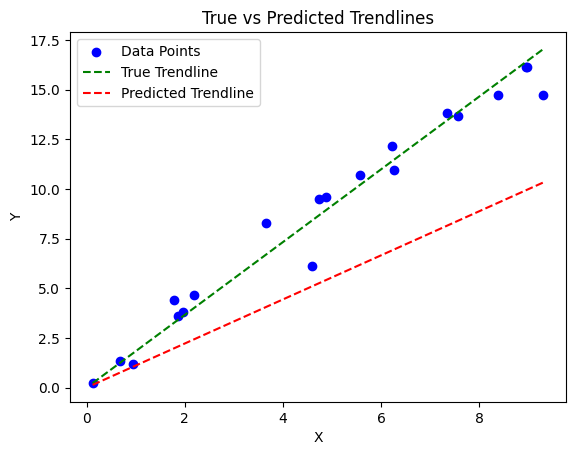

In [34]:
class linearRegression_guesser(torch.nn.Module):
    def __init__(self, num_points = 20):
        super(linearRegression_guesser, self).__init__()
        self.fc1 = nn.Linear(num_points, 100)

        self.fc2 = nn.Linear(100, num_points)

        self.fc3 = nn.Linear(num_points, 100)

        self.fc4 = nn.Linear(100, num_points)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, input):
        x = input[:,0,:]
        # print("x",x.shape,x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = x.unsqueeze(-1)
        # print("x",x.shape,x)
        y = input[:,1,:]
        y = self.relu(self.fc3(y))
        y = self.relu(self.fc4(y))
        # print("y",y.shape,y)
        y = y.unsqueeze(-1)
        # print("y",y.shape,y)
        # print("y",y.shape)
        # ones = torch.ones_like(x)
        # print("ones",ones.shape)
        # X = torch.stack((ones, x),dim=1)
        # print("X",X.shape, X)
        beta_hat = torch.linalg.inv(x.permute(0,2,1) @ x) @ x.permute(0,2,1) @ y

        return beta_hat


def plot_dot_graph(values):
    """Plots an array of values as a dot point graph."""
    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(values)), values, color='b', label='Data Points')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Dot Point Graph')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def Train(model,train_loader, epochs,lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradients = []
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input,target = batch
            # print("input",input.shape)
            # print("target", target.shape)
            optimizer.zero_grad()
        
            # get output from the model, given the inputs
            outputs = model(input)
            # print("x",x.shape, x)
            # print("output",outputs.shape, outputs)
            # print("target",target.shape, target)
            # get loss for the predicted output
            loss = criterion(outputs, target)
            # print(loss)
            # get gradients w.r.t to parameters
            loss.backward()
            for name, param in model.named_parameters():
                if param.grad is not None:
                    gradients.append(param.grad.norm().item())
            optimizer.step()
    
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    plot_dot_graph(gradients)    

def visualise_predictions(model, data,index = 0):
    data_points = np.take(data[0], indices=index, axis=0)
    # print("d_points",data_points.shape,data_points)
    x_values = data_points[0, :]  # Extract x-values
    y_values = data_points[1, :] 
    true_coeff = data[1][index]
    # print(true_coeff)

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for efficiency
        input = torch.tensor(np.expand_dims(data_points, axis=0), dtype=torch.float32)
        # print("input",input.shape,input)
        predicted_coeff = model(input).numpy()[0][0]
        # print(predicted_coeff)
    
    plt.scatter(x_values, y_values, label="Data Points", color="blue")

    # Define the range for trendlines
    x_line = np.linspace(min(x_values), max(x_values), 100)

    # True trendline: y = true_coeff * x
    y_true = true_coeff * x_line
    plt.plot(x_line, y_true, label="True Trendline", linestyle="dashed", color="green")

    # Predicted trendline: y = predicted_coeff * x
    y_pred = predicted_coeff * x_line
    plt.plot(x_line, y_pred, label="Predicted Trendline", linestyle="dashed", color="red")

    # Labels and legend
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.title("True vs Predicted Trendlines")

    # Show the plot
    plt.show()




learning_rate = 0.00001
num_epochs = 2

model = linearRegression_guesser()
visualise_predictions(model,val_data)
Train(model,train_loader,num_epochs,learning_rate)
visualise_predictions(model,val_data,index=0)


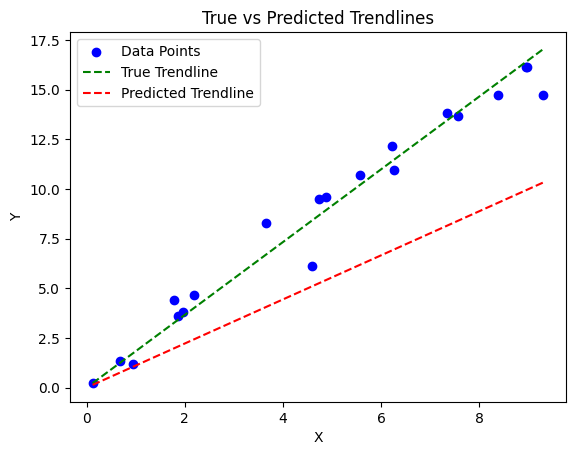

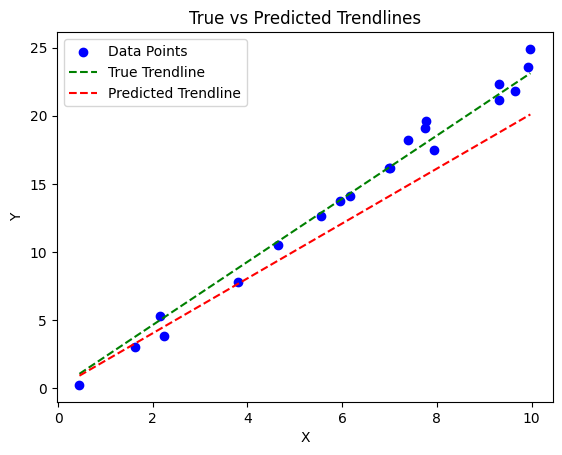

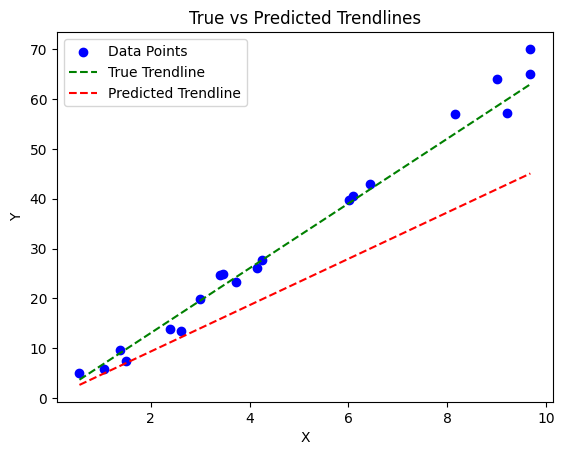

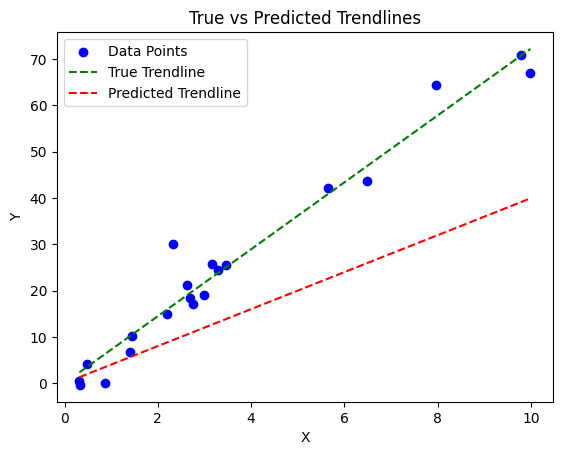

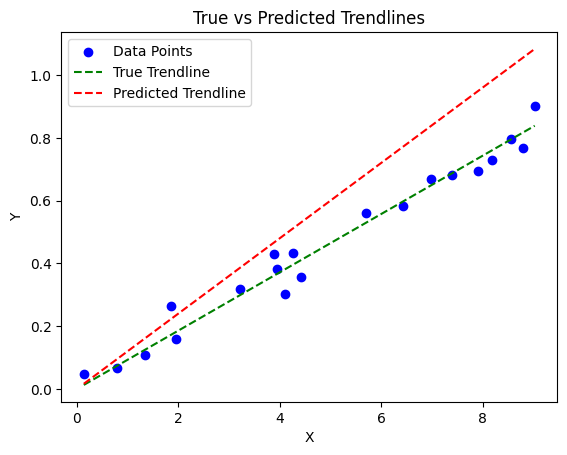

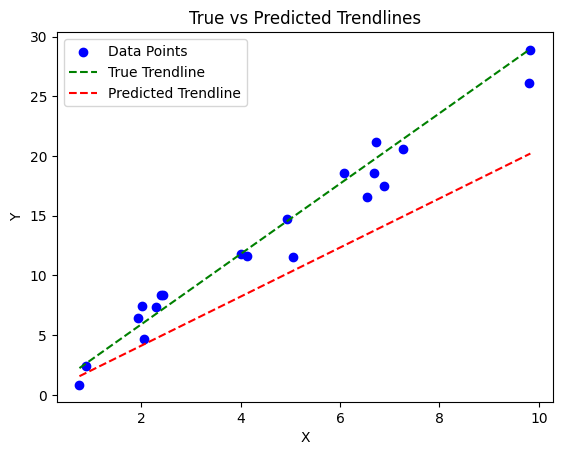

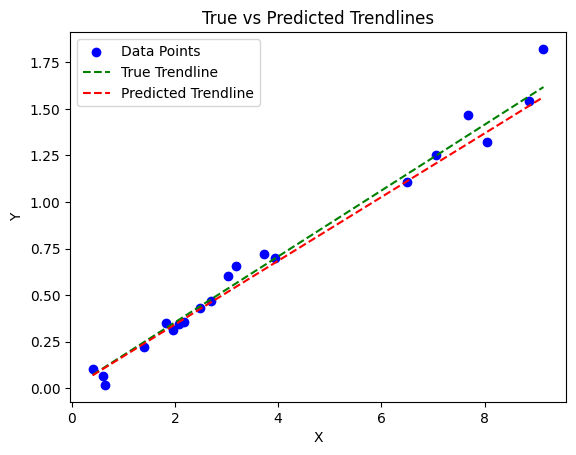

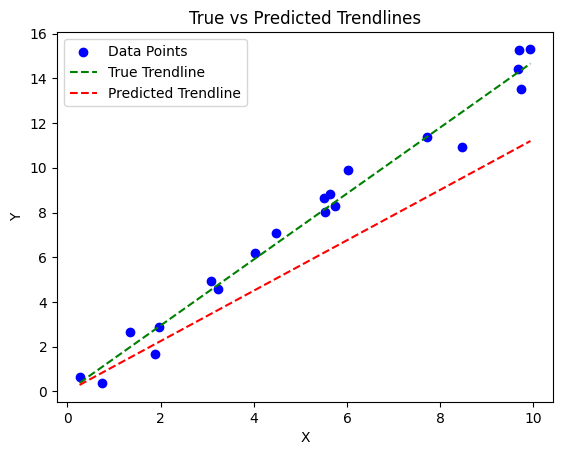

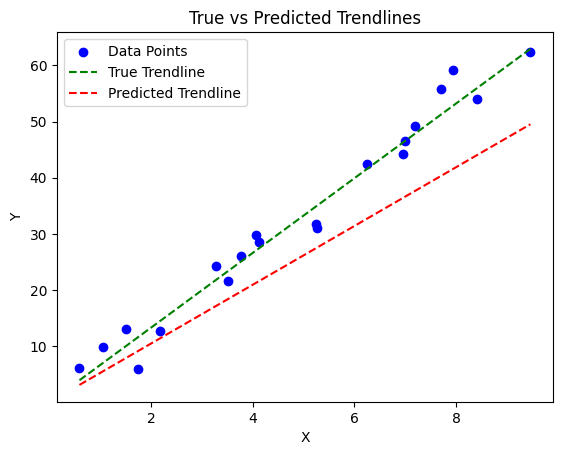

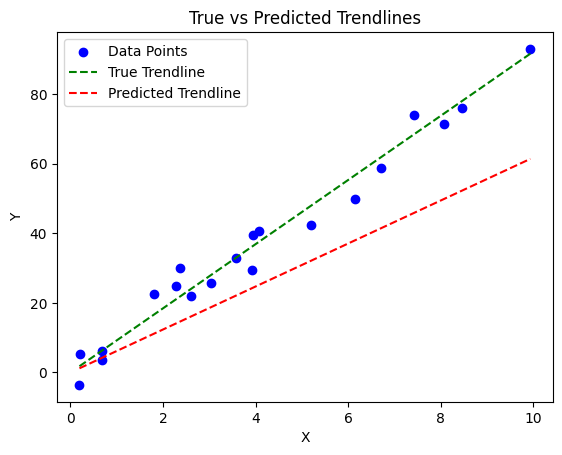

In [35]:
visualise_predictions(model,val_data)
visualise_predictions(model,val_data,index=1)
visualise_predictions(model,val_data,index=2)
visualise_predictions(model,val_data,index=3)
visualise_predictions(model,val_data,index=4)
visualise_predictions(model,val_data,index=5)
visualise_predictions(model,val_data,index=6)
visualise_predictions(model,val_data,index=7)
visualise_predictions(model,val_data,index=8)
visualise_predictions(model,val_data,index=9)

In [25]:
import torch

def linear_regression_torch(x, y):
    # Ensure x and y are torch tensors
    x = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
    print(x.shape)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    print(y.shape)
    # Construct the design matrix X with a column of ones
    ones = torch.ones_like(x)
    X = torch.cat((ones, x), dim=1)  # Shape (n, 2)
    print(X.shape)
    # Compute the least squares estimate using matrix inversion
    beta_hat = torch.linalg.inv(X.T @ X) @ X.T @ y
    
    return beta_hat

# Example usage:
x_data = [1, 2, 3, 4, 5]
y_data = [2.2, 2.8, 3.6, 4.5, 5.1]

beta = linear_regression_torch(x_data, y_data)
print("Estimated coefficients:", beta.flatten().tolist())


torch.Size([5, 1])
torch.Size([5, 1])
torch.Size([5, 2])
Estimated coefficients: [1.3900011777877808, 0.7499994039535522]
